# Tecnológico de Monterrey
## Maestría en Inteligencia Artificial Aplicada
---

### **Materia:** Proyecto Integrador

---

### **Avance 3:** Baseline

---

### **Proyecto:** Chatbot jurídico para soporte informativo en el análisis de carpetas de investigación

---

### **Profesora:** Dra. Grettel Barceló Alonso
### **Asesor:** Dr. Horacio Martínez Alfaro

---
### **Equipo 42 - Autorización individual**
### A00841954 Christian Erick Mercado Flores

---

Fecha: 12 de Octubre de 2025

### **Descripción del Proyecto**

En el marco del desarrollo de la materia de Proyecto Integrador, el presente trabajo propone el desarrollo del proyecto que lleva por título: **Chatbot jurídico para soporte informativo en el análisis de carpetas de investigación.**

La institución con la cual se colaborará y donde se implementará el proyecto es la **Fiscalía Especializada en Combate a la Corrupción del Estado de Michoacán**, también conocida como la **Fiscalía Anticorrupción de Michoacán**.

Específicamente, el área dentro de la institución donde se pondrá en marcha el trabajo es la **Unidad de Delitos Cometidos por Servidores Públicos y Particulares**.

### **Objetivo del Proyecto**

Poner a disposición de los agentes de la **Unidad de Delitos Cometidos por Servidores Públicos y Particulares** de la **Fiscalía Anticorrupción de Michoacán**, un **chatbot conversacional** que pueda proveer **soporte informativo** a partir del **marco jurídico aplicable** y de **carpetas de investigación** centralizados en un sistema de archivos.

### **Descripción del trabajo**

En el presente entregable se completa el flujo de trabajo al integrar la sección de **Algoritmo** representada por el **Modelo Baseline del Sistema RAG**. Así pues, se detalla el sistema **RAG** a utilizar para generar las salidas del proyecto. Este sistema está integrado en esta etapa por una **Base de Datos Vectorial** y un **LLM**, con el objetivo de recuperar documentos con base en similitud coseno y mostrar una respuesta con relación a esos documentos que forman un contexto.

Al final, se detallan diferentes métricas para evaluar esta propuesta del **Modelo Baseline**, y dar conclusiones sobre cómo proceder en las siguientes entregas.

# Índice

#### 1. Librarías y Constantes

#### 2. Construcción de Corpus de Texto

#### 3. Preprocesamiento de Corpus de Texto

#### 4. Generación de *Embeddings*

#### 5. Modelo Baseline
  * 5.1. Algoritmo
    * a) Base de Datos Vectorial
    * b) Large Language Models (*LLM*)
    * c) Configuración Sistema *RAG*

  * 5.2. Características Importantes

  * 5.3. Evaluación de Desempeño
    * a) Evaluación de Recuperación
    * b) Evaluación de Respuesta

#### 6. Conclusiones

#### 7. Referencias

# 1. Librarías y Constantes

In [1]:
pip install -q pandas numpy matplotlib seaborn tqdm tika pdfplumber python-docx pillow spacy python-magic qdrant-client scikit-learn nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importación de Librearías

# 1) Librerías Estándar de Python
import math
import mimetypes
import os
import re
import unicodedata
from datetime import datetime
from pathlib import Path

# 2) Librerías de Terceros
import magic
import matplotlib.pyplot as plt
import requests
import nltk
import numpy as np
import pandas as pd
import pdfplumber
import seaborn as sns
import torch
from docx import Document
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
from scipy import stats
from scipy.stats import kurtosis, skew
from tika import parser as tika_parser
from torch import Tensor
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, pipeline
from qdrant_client import QdrantClient, models
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# 3) Configuración y Descargas
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Configuración de Constantes

# 1) Definición de la carpeta base
BASE_DIR = Path("./file-system")

# 2) Definición de subcarpetas específicas
CARPETAS_DIR = BASE_DIR / "CARPETAS"
MARCO_LEGAL_DIR = BASE_DIR / "MARCO-LEGAL"

# 3) Configuración del conjunto de stopwords en español
SPANISH_STOP = set(stopwords.words('spanish')) if 'spanish' in stopwords.fileids() else set()

# 2. Construcción de Corpus de Texto

En esta sección se procedió a la **construcción de un corpus de textos** que representa los datos con lo cuales el proyecto "Chatbot jurídico para soporte informativo en el análisis de Carpetas de Investigación" va a trabajar. Este corpus está integrado por los siguientes tipos de documentos:
  - Documentos del **Marco Jurídico**: contienen textos que están divididos estructuralmente siguiendo una lógica jurídica (como capítulos, secciones, artículos, etc.). Provienen de instituciones, entidades y fuentes legales (como Código Penal para el Estado de Michoacán, Ley Orgánica de la Fiscalía General del Estado de Michoacán, etc.).

  - Documentos de **Carpetas de Investigación**: tienen textos escritos siguiendo una narrativa legal o jurídica, o siguiendo formatos administrativo-legales. Se generan dentro de la propia Unidad de la Fiscalía con la que se trabaja en el proyecto.

In [4]:
def process_files(base_path):
    """
    Recorre recursivamente los archivos dentro de un directorio base y construye
    un DataFrame con metadatos de cada archivo encontrado.

    Parámetros:
        base_path (Path) : Objeto Path que indica el directorio base a recorrer.

    Retorno:
        pd.DataFrame : DataFrame que contiene una fila por archivo con las siguientes
                       columnas:
                       - "path"       (str)  : Ruta completa del archivo.
                       - "name"       (str)  : Nombre base del archivo sin extensión.
                       - "size_bytes" (int)  : Tamaño del archivo en bytes.
                       - "mime"       (str)  : Tipo MIME detectado o estimado del archivo.
    """

    # 1) Inicialización de estructura para almacenar resultados
    rows = []  # Lista donde se guardarán los metadatos de cada archivo

    # 2) Recorrido recursivo de todos los elementos en el directorio base
    for p in base_path.rglob("*"):  # Itera sobre todos los archivos y carpetas
        if p.is_file():             # Solo procesa si es archivo

            # 3) Obtención de metadatos básicos del archivo
            stat = p.stat() # Se obtiene información del sistema sobre el archivo
            mime = None     # Inicializa el valor MIME como None

            # 4) Intento de detección precisa del tipo MIME
            try:
                mime = magic.from_file(str(p), mime=True)  # Detecta MIME con librería 'magic'
            except Exception:
                mime = mimetypes.guess_type(p)[0]  # Estima MIME como fallback usando 'mimetypes'

            # 5) Almacenamiento de resultados en la lista de filas
            rows.append({
                "path": str(p),             # Ruta completa del archivo
                "name": p.stem,             # Nombre del archivo sin extensión
                "size_bytes": stat.st_size, # Tamaño en bytes
                "mime": mime,               # Tipo MIME detectado o estimado
            })

    # 6) Conversión de resultados a DataFrame
    return pd.DataFrame(rows)  # Retorna la estructura tabular con metadatos

In [5]:
# Procesamiento de archivos y muestra de estadísticas

# 1) Obtención de DataFrames con los archivos procesados
carpetas_df = process_files(CARPETAS_DIR)
marco_juridico_df = process_files(MARCO_LEGAL_DIR)

# 2) Impresión de resultados de conteo de archivos procesados
print(f"=== Archivos Procesados ==")
print(f"Archivos de Carpetas de Investigación: {len(carpetas_df)}")
print(f"Archivos de Marco Jurídico: {len(marco_juridico_df)}")

=== Archivos Procesados ==
Archivos de Carpetas de Investigación: 53
Archivos de Marco Jurídico: 24


In [6]:
# Vista previa de los primeros registros
carpetas_df.head()

,path,name,size_bytes,mime
0,file-system/CARPETAS/2025-MICH-FECC-0002456/2-...,acuerdo_de inicio_de_carpeta_de_investigacion,125848,application/pdf
1,file-system/CARPETAS/2025-MICH-FECC-0002456/2-...,acta_de_lectura_de_derechos,121285,application/pdf
2,file-system/CARPETAS/2025-MICH-FECC-0002456/2-...,constancia_de_asignacion_de_numero_de_carpeta,105890,application/pdf
3,file-system/CARPETAS/2025-MICH-FECC-0002456/1-...,lista_de_anexos,140763,application/pdf
4,file-system/CARPETAS/2025-MICH-FECC-0002456/1-...,acta_de_recepcion,111097,application/pdf


In [7]:
# Información general del DataFrame
carpetas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        53 non-null     object
 1   name        53 non-null     object
 2   size_bytes  53 non-null     int64 
 3   mime        53 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.8+ KB


In [8]:
# Vista previa de los primeros registros
marco_juridico_df.head()

,path,name,size_bytes,mime
0,file-system/MARCO-LEGAL/TIPO-DELITO/codigo_pen...,codigo_penal_para_el_estado_de_michoacan,1940655,application/pdf
1,file-system/MARCO-LEGAL/TIPO-DELITO/ley_organi...,ley_organica_de_la_fiscalia_general_del_estado...,616234,application/pdf
2,file-system/MARCO-LEGAL/TIPO-DELITO/reglamento...,reglamento_de_la_ley_organica_de_la_fiscalia_g...,1382808,application/pdf
3,file-system/MARCO-LEGAL/PROCESO-PENAL/corte_in...,corte_interamericana_de_derechos_humanos_caso_...,711015,application/pdf
4,file-system/MARCO-LEGAL/PROCESO-PENAL/jurispru...,jurisprudencia_responsabilidades_administrativas,10130803,application/pdf


In [9]:
# Información general del DataFrame
marco_juridico_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        24 non-null     object
 1   name        24 non-null     object
 2   size_bytes  24 non-null     int64 
 3   mime        24 non-null     object
dtypes: int64(1), object(3)
memory usage: 900.0+ bytes


In [10]:
def separate_files_by_case(df):
    """
    Separa un DataFrame en múltiples subconjuntos según el nombre del caso
    (extraído del path del archivo). Cada subconjunto se almacena en un
    diccionario, donde la clave es el nombre del caso y el valor es el
    DataFrame correspondiente.

    Parámetros:
        df (pd.DataFrame) : DataFrame que contiene al menos una columna 'path'
                            con rutas de archivos (por ejemplo: /data/case1/file.pdf).

    Retorno:
        dict : Diccionario donde:
               - "clave" (string)       : Nombre del caso
               - "valor" (pd.DataFrame) : DataFrame con los registros pertenecientes a ese caso
    """

    # 1) Crear una nueva columna 'case' extrayendo el nombre del caso del path
    #    Se asume que el nombre del caso está en la tercera posición del path (índice 2)
    df['case'] = df['path'].apply(lambda x: x.split('/')[2])

    # 2) Inicializar un diccionario para guardar los DataFrames por caso
    dfs_by_folder = {}

    # 3) Agrupar el DataFrame principal por el nombre del caso
    groups = df.groupby('case')

    # 4) Iterar sobre cada grupo (cada caso)
    for folder_name, df_group in groups:
        # Crear una copia del DataFrame del grupo sin la columna auxiliar 'case'
        df_final = df_group.drop(columns=['case']).copy()

        # Guardar el DataFrame en el diccionario con la clave del nombre del caso
        dfs_by_folder[folder_name] = df_final

    # 5) Devolver el diccionario de DataFrames
    return dfs_by_folder

In [11]:
# Separación de los archivos en diferentes DataFrames según el caso identificado en el path

# 1) Llamada a la función que organiza los archivos por carpeta de investigación
carpetas_dfs = separate_files_by_case(carpetas_df)

# 2) Visualización de los nombres de las carpetas de investigación obtenidas
print("=== Diferentes Carpetas de Investigación (Folios) ===")
print(carpetas_dfs.keys())

=== Diferentes Carpetas de Investigación (Folios) ===
dict_keys(['2025-MICH-FECC-0001789', '2025-MICH-FECC-0002456'])


# 3. Preprocesamiento de Corpus de Texto

En esta sección se procedió con el **preprocesamiento del corpus de texto**. Este proceso es sustancialmente diferente al preprocesamiento de los tipos de datos numéricos o categóricos. Pues, el procesar los textos no se trata de una tarea de buscar valores atípicos, faltantes o imputar cifras, sino que la tarea en realidad es preservar tanto la estructura lógica e integridad semántica de los textos (Ferraris et al., 2024), toda vez que son procesados para que los modelos de *Machine Learning* puedan utilizarlos. Para esta tarea de preprocesamiento se utilizaron técnicas de Procesamiento de Lenguaje Natural o *Natural Language Processing* (*NLP*). Específicamente se aplicaron técnicas de *Tokenización* (dividir el texto en unidades más pequeñas como palabras, subpalabras o caracteres) y *Chunking* (dividir fragmentos de texto o *tokens* en segmentos) (Vaj, 2024).

Los procesos que se implementaron fueron los siguientes:

  - ***Tokenización***: tanto los documentos del **Marco Jurídico** como los de las **Carpetas de Investigación** representan textos que siguen una lógica narrativa y descriptiva propia del campo legal. Aunque los documentos del **Marco Jurídico** presentan estructuras más rígidas (como artículos) y los del las **Carpetas de Investigación** tiene una narrativa más administrativa y legal, en ambos casos, la puntuación, los saltos de línea y la estructura son importantes para mantener el contexto semántico de los textos. En este sentido, se procedió con una limpieza de texto más simple para que el contenido no se perdiera, aplicando normalizando Unicode, convirtiendo a minúsculas y preservando puntuación.

  - ***Chunking***: para cada tipo de documento se siguió una division de *chunks* distinta, derivado de la naturaleza de los mismos. Sin embargo, al realizar el *overlapping* entre *tokens* de los *chunks* para preservar el contexto, se siguió la misma técnica que fue basada en el método descrito en el artículo "*No Argument Left Behind: Overlapping Chunks for Faster Processing of Arbitrarily Long Legal Texts*" (Fama et al., 2024). El proceso de *overlapping* aplicado fue calcular un porcentaje de *tokens* al inicio y final de cada *chunk*, representada por la métrica `Z`, para hacer un *overlapping* con los vecinos adyacentes, creando así una superposición simétrica de `Z/2` *tokens* en los límites de cada *chunk* adyacente para preservar el contexto. Las dimensiones de los *chunks* fueron determinadas de la siguiente manera para cada documento:

    * Documentos de **Carpetas de Investigación**: estos documentos no presentan una estructura larga de *tokens* ni presenta estructuras rígidas como artículos. Por lo tanto, se determinó una dimension estándar de 512 posiciones de *tokens* por *chunk* con el objetivo de granular el contexto, pero sin dividirlo mucho, aplicando un *overlapping* de 5%.

    * Documentos del **Marco Jurídico**: estos documentos presentan estructuras más rígidas, por lo que se procedió a generar *chunks* basados en estructuras mediante la identificación de estas a través de expresiones regulares. Debido a que estas mismas estructuras son muy variables en tamaño, se determinó generar límites de dimensión para las posiciones de *tokens* en los *chunks*. Así, se estipuló una dimensión mínima de 512 posiciones estándar y un máximo de 4,096 *tokens* que representan de las ventanas más grandes propuestas en la literatura, aplicando un *overlapping* de 5%.

In [12]:
def extract_text_pdf(path):
    """
    Extrae el contenido textual de un archivo PDF.

    Parámetros:
        path (str) : Ruta al archivo PDF a procesar.

    Retorno:
        str : Texto completo extraído del PDF. Si ocurre un error, retorna cadena vacía.
    """

    # 1) Manejo de errores generales
    try:

        # 2) Inicialización de lista para almacenar texto de cada página
        texts = []

        # 3) Apertura del PDF y extracción de texto por página
        with pdfplumber.open(path) as pdf:
            for page in pdf.pages:
                texts.append(page.extract_text() or "") # Extrae texto o agrega cadena vacía

        # 4) Unión de todos los textos en un solo string
        return "\n".join(texts)

    # 5) Retorno en caso de error durante la extracción
    except Exception as e:
        return ""

In [13]:
def extract_text_docx(path):
    """
    Extrae el contenido textual de un archivo DOCX.

    Parámetros:
        path (str) : Ruta al archivo DOCX a procesar.

    Retorno:
        str : Texto completo extraído del DOCX. Si ocurre un error, retorna cadena vacía.
    """

    # 1) Manejo de errores generales
    try:

        # 2) Apertura del documento DOCX
        doc = Document(path)

        # 3) Extracción del texto de cada párrafo
        parts = [p.text for p in doc.paragraphs]

        # 4) Unión de todos los textos en un solo string
        return "\n".join(parts)

    # 5) Retorno en caso de error durante la extracción
    except Exception:
        return ""

In [14]:
def extract_text_tika(path):
    """
    Extrae el contenido textual de un archivo usando Apache Tika.

    Parámetros:
        path : Ruta al archivo a procesar con Tika.

    Retorno:
        str : Texto completo extraído del archivo. Si ocurre un error, retorna cadena vacía.
    """

    # 1) Manejo de errores generales
    try:

        # 2) Parseo del archivo usando Tika
        parsed = tika_parser.from_file(path)
        content = parsed.get('content') or parsed.get('text') or "" # Obtiene contenido principal

        # 3) Decodificación si el contenido está en bytes
        if isinstance(content, bytes):
            try:
                content = content.decode('utf-8', errors='ignore')
            except Exception:
                content = str(content)  # Fallback a string estándar si falla decodificación

        # 4) Retorno del contenido extraído
        return content or ""

    # 5) Retorno en caso de error durante la extracción
    except Exception:
        return ""

In [15]:
def extract_text(path):
    """
    Extrae el texto de un archivo aplicando primero métodos específicos por tipo
    de archivo y, si fallan, utiliza Tika como fallback.

    Parámetros:
        path (str) : Ruta al archivo a procesar.

    Retorno:
        str : Texto completo extraído del archivo, limpio de espacios iniciales y finales.
    """

    # 1) Determinar la extensión del archivo
    ext = Path(path).suffix.lower()
    text = ""

    # 2) Procesamiento de PDFs
    if ext == '.pdf':
        text = extract_text_pdf(path)       # Intento preferido con pdfplumber
        if not text:
            text = extract_text_tika(path)  # Fallback a Tika si falla

    # 3) Procesamiento de archivos Word
    elif ext in ['.docx', '.doc']:
        text = extract_text_docx(path)      # Intento preferido con python-docx
        if not text:
            text = extract_text_tika(path)  # Fallback a Tika si falla

    # 4) Procesamiento de archivos de texto plano o Markdown
    elif ext in ['.txt', '.md']:
        try:
            with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()             # Lectura directa de archivo
        except Exception:
            text = extract_text_tika(path)  # Fallback a Tika si falla

    # 5) Otros tipos de archivo
    else:
        text = extract_text_tika(path)      # Uso directo de Tika

    # 6) Retorno del texto limpio
    return (text or "").strip()

In [16]:
def generate_tokens(text):
    """
    Tokeniza un texto realizando normalización Unicode, manejo de saltos de línea
    y filtrado de tokens vacíos. Convierte saltos de línea en tokens especiales
    para preservar la estructura del texto.

    Parámetros:
        text (str) : Texto de entrada a tokenizar.

    Retorno:
        list : Lista de tokens procesados, incluyendo '\n' para saltos de línea.
    """

    # 1) Verificar texto vacío
    if not text:
        return []

    # 2) Normalización Unicode y conversión a minúsculas
    text = unicodedata.normalize('NFKC', text).lower()

    # 3) Reemplazar saltos de línea por un marcador temporal y limpiar espacios múltiples
    text = text.replace('\n', ' NEWLINE_TOKEN ')
    text = re.sub(r'\s+', ' ', text).strip()

    # 4) Tokenización básica usando word_tokenize
    tokens = word_tokenize(text)

    # 5) Reemplazar marcador por '\n' y filtrar tokens vacíos
    final_tokens = []
    for t in tokens:
        if t.lower() == 'newline_token':  # Reemplaza el marcador por salto de línea
            final_tokens.append('\n')
        elif t.strip():                   # Evitar tokens vacíos
            final_tokens.append(t)

    # 6) Retorno de la lista final de tokens
    return final_tokens

In [17]:
def generate_chunks(tokens, chunk_size=512, overlap_percent=0.05):
    """
    Genera chunks con solapamiento siguiendo el método del artículo
    'No Argument Left Behind: Overlapping Chunks for Faster Processing of Arbitrarily Long Legal Texts'.

    Parámetros:
        tokens (list)           : Lista de tokens.
        chunk_size (int)        : Tamaño máximo de tokens por chunk.
        overlap_percent (float) : Porcentaje de solapamiento entre chunks (0 a 1).

    Retorno:
        list : Lista de chunks con solapamiento.
    """

    # 1) Verificar que la lista de tokens no esté vacía
    if not tokens:
        return []

    # 2) Inicialización de lista de chunks y cálculo de parámetros
    chunks = []                                     # Lista donde se almacenarán los chunks generados
    total_tokens = len(tokens)                      # Número total de tokens
    z = int(chunk_size * overlap_percent)           # Número de tokens compartidos entre chunks
    z_half = z // 2                                 # Mitad del solapamiento para avanzar la ventana

    # 3) Generación de chunks con solapamiento
    start = 0
    while start < total_tokens:
        end = min(start + chunk_size, total_tokens) # Límite superior del chunk
        chunks.append(tokens[start:end])            # Añadir chunk a la lista
        start += chunk_size - z_half                # Avanzar la ventana teniendo en cuenta el solapamiento

    # 4) Retorno de la lista de chunks
    return chunks

In [18]:
def generate_chunks_legal_structures(tokens, overlap_percent=0.05, min_tokens=512, max_tokens=4096):
    """
    Genera chunks de texto a partir de estructuras legales con solapamiento dinámico.
    Conserva la lógica original de overlapping (z, z_half), evitando exceder el límite de tokens.

    Parámetros:
        tokens (list[str])      : Lista de tokens del texto procesado.
        overlap_percent (float) : Porcentaje de solapamiento dinámico entre chunks.
        min_tokens (int)        : Tamaño mínimo permitido por chunk.
        max_tokens (int)        : Tamaño máximo permitido por chunk.

    Retorna:
        list[list[str]] : Lista de chunks (listas de tokens).
    """

    # 1) Definición de patrones de división por estructuras legales.
    # Estos patrones permiten identificar divisiones naturales dentro de textos normativos o jurídicos.
    split_patterns = [
        r'LIBRO\s+[IVXLC\d]+',           # División jerárquica mayor (ej: LIBRO PRIMERO)
        r'TÍTULO\s+[IVXLC\d]+',          # División jerárquica principal (ej: TÍTULO II)
        r'CAPÍTULO\s+[IVXLC\d]+',        # División jerárquica media (ej: CAPÍTULO V)
        r'SECCIÓN\s+[IVXLC\d]+',         # Subdivisión de Capítulo o Título
        r'SUBSECCIÓN\s+[IVXLC\d]+',      # Subdivisión de Sección
        r'APARTADO\s+[A-Z\d]+',          # División interna de Artículos o Capítulos
        r'FRACCIÓN\s+[IVXLC\d]+',        # Elemento clave de subdivisión legal
        r'INCISO\s+[A-Z]',               # Elemento de subdivisión menor
        r'Artículo\s+\d+[A-Za-z]*',      # Artículo completo (ej: Artículo 12 Bis)
        r'Art\.\s*\d+[A-Za-z]*',         # Artículo abreviado (ej: Art. 12 Ter)
        r'^\d+\.\s*',                    # Párrafos que inician con numeración (ej: 1. El Tribunal...)
        r'Justificación:?\s*',           # Cabecera común en sentencias y dictámenes
        r'Criterio jurídico:?\s*',       # Cabecera de Tesis o Criterio
        r'Hechos:?\s*',                  # Cabecera de la sección de Antecedentes o Hechos
        r'Fundamento[s]?:?\s*'           # Cabecera de la sección de Sustento Legal
    ]
    combined_pattern = r'(?im)(' + '|'.join(split_patterns) + ')'

    # 2) División inicial del texto en partes basadas en las estructuras detectadas.
    text = ' '.join(tokens)
    splits = re.split(combined_pattern, text)
    splits = [s.strip() for s in splits if s.strip()]

    base_chunks = []
    current_chunk = []

    # 3) Agrupación de tokens según las divisiones encontradas.
    for part in splits:
        if re.match(combined_pattern, part):  # Si es una cabecera legal, inicia un nuevo chunk
            if current_chunk:
                base_chunks.append(current_chunk.copy())
                current_chunk = []
            current_chunk.extend(part.split())
        else:  # Si es contenido, se añade al chunk actual
            current_chunk.extend(part.split())

    if current_chunk:
        base_chunks.append(current_chunk.copy())

    # 4) Subdivisión con solapamiento dinámico para mantener coherencia entre chunks.
    final_chunks = []

    for chunk in base_chunks:
        chunk_size = len(chunk)
        if chunk_size == 0:
            continue

        start = 0
        while start < chunk_size:
            end = min(start + max_tokens, chunk_size) # Límite superior del sub-chunk (sin exceder el máximo permitido)
            sub_chunk = chunk[start:end]              # Extrae la ventana de tokens desde 'start' hasta 'end'

            # Si el sub-chunk resultante es demasiado pequeño, se intenta unir con el anterior.
            if len(sub_chunk) < min_tokens and final_chunks:
                if len(final_chunks[-1]) + len(sub_chunk) <= max_tokens:  # Solo se une si no rebasa el máximo
                    final_chunks[-1].extend(sub_chunk)                    # Se fusiona con el último chunk anterior
                else:
                    final_chunks.append(sub_chunk)                        # Si no cabe, se agrega como nuevo chunk independiente
            else:
                final_chunks.append(sub_chunk)                            # Caso normal: se agrega el sub-chunk directamente

            # 5) Cálculo del solapamiento dinámico.
            z = int(len(sub_chunk) * overlap_percent) # Calcula el número de tokens que deben solaparse
            z_half = z // 2                           # Usa la mitad del solapamiento para suavizar la transición
            start += len(sub_chunk) - z_half          # Avanza el índice con solapamiento parcial (no total)

            # Protección: evita bucles infinitos o posiciones fuera del rango del chunk
            if start >= chunk_size or len(sub_chunk) == 0:
                break  # Sale del bucle si se llegó al final o no hay tokens válidos

    return final_chunks

In [19]:
def process_text_and_generate_chunks(files_df, are_legal_structures=False):
    """
    Procesa archivos para extraer y segmentar el texto en chunks listos para vectorización.

    Parámetros:
        files_df (pd.DataFrame)     : DataFrame con al menos las columnas 'path' y 'name'.
        are_legal_structures (bool) : Si True, usa chunking basado en estructura legal.

    Retorno:
        pd.DataFrame : DataFrame con los chunks generados. Cada fila contiene el nombre del documento,
                       un identificador de chunk, el texto correspondiente y metadata de tokens y chunks.
    """

    # 1) Inicialización de lista donde se almacenarán los chunks generados
    chunks_list = []

    # 2) Iteración sobre cada archivo en el DataFrame para procesar su texto
    for idx, row in tqdm(files_df.iterrows(), total=len(files_df)): # Se usa tqdm para mostrar el progreso del bucle
        path = row['path']
        doc_name = row['name']
        text = extract_text(path)                                   # Extrae el texto del archivo
        clean_tokens = generate_tokens(text)

        # 3) Procesamiento del texto según el tipo de estructura (legal o de expediente)
        if are_legal_structures:                                    # Si se indica que el documento tiene estructura legal
            chunks = generate_chunks_legal_structures(clean_tokens)
        else:                                                       # Si no es un documento legal, aplica un procesamiento estándar
            chunks = generate_chunks(clean_tokens, chunk_size=512)

        # 4) Construcción de la lista de chunks con su respectiva metadata
        for i, chunk in enumerate(chunks):
            chunks_list.append({
                'doc_name': doc_name,
                'text': ' '.join(chunk),
                'chunk_size': len(chunk),
            })

    # 5) Retorno del resultado como DataFrame para facilitar su análisis y vectorización
    return pd.DataFrame(chunks_list)

In [20]:
def plot_chunks(df, title, column='chunk_size'):
    """
    Genera un histograma que muestra la distribución del tamaño de los chunks
    (fragmentos de texto) dentro de un DataFrame, añadiendo una línea vertical
    que indica la media del tamaño de los chunks.

    Parámetros:
        df (pd.DataFrame) : DataFrame que contiene los datos de chunks.
        title (str)       : Título descriptivo para el gráfico.
        column (str)      : Nombre de la columna que contiene los tamaños de los chunks.
                            Por defecto es 'chunk_size'.

    Retorno:
        None : La función no retorna ningún valor, solo muestra el gráfico.
    """

    # 1) Validación de existencia de la columna a graficar
    if column not in df.columns:
        raise ValueError(f"La columna '{column}' no existe en el DataFrame.")  # Validación temprana de integridad

    # 2) Cálculo del valor medio de la columna seleccionada
    mean_value = df[column].mean()  # Obtiene la media del tamaño de los chunks

    # 3) Configuración del estilo visual de Seaborn
    sns.set(style="whitegrid")  # Define un estilo limpio con fondo cuadriculado

    # 4) Creación del gráfico de histograma
    plt.figure(figsize=(8, 5))                                    # Define el tamaño de la figura
    sns.histplot(df[column], bins=30, kde=True, color='skyblue')  # Dibuja el histograma con densidad KDE

    # 5) Adición de línea vertical indicando la media
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f"Media = {mean_value:.1f}")  # Línea de media

    # 6) Configuración de títulos, etiquetas y leyenda
    plt.title(f"Distribución de {column} para {title}", fontsize=13, weight='bold')
    plt.xlabel("Tamaño de Chunk en número de Tokens")
    plt.ylabel("Frecuencia")

In [21]:
# Procesamiento de metadatos de archivos de carpetas y vista previa

# 1) Generación de DataFrame chunks
carpetas_chunks_dfs = {
    key: process_text_and_generate_chunks(value, False)
    for key, value in carpetas_dfs.items()
}

# 2) Información general del DataFrame
for key, df in carpetas_chunks_dfs.items():
    print(f"\n=== Información de la Carpeta de Investigación: {key} ===\n")
    display(df.info())

100%|██████████| 23/23 [00:04<00:00,  5.09it/s]


=== Información de la Carpeta de Investigación: 2025-MICH-FECC-0001789 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   doc_name    93 non-null     object
 1   text        93 non-null     object
 2   chunk_size  93 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ KB


None


=== Información de la Carpeta de Investigación: 2025-MICH-FECC-0002456 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   doc_name    87 non-null     object
 1   text        87 non-null     object
 2   chunk_size  87 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ KB


None

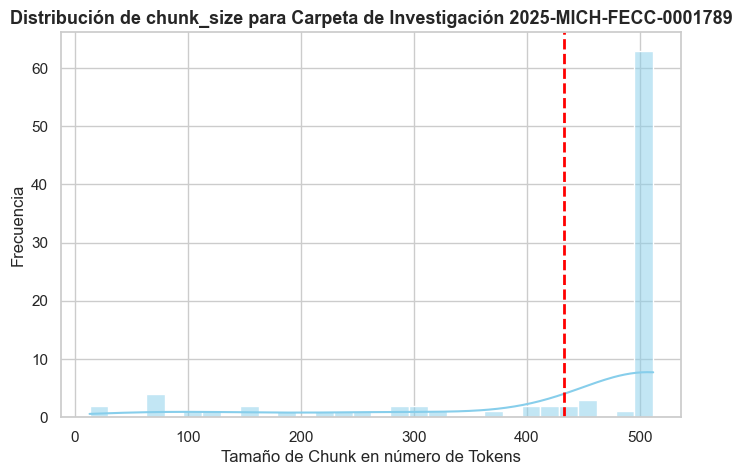

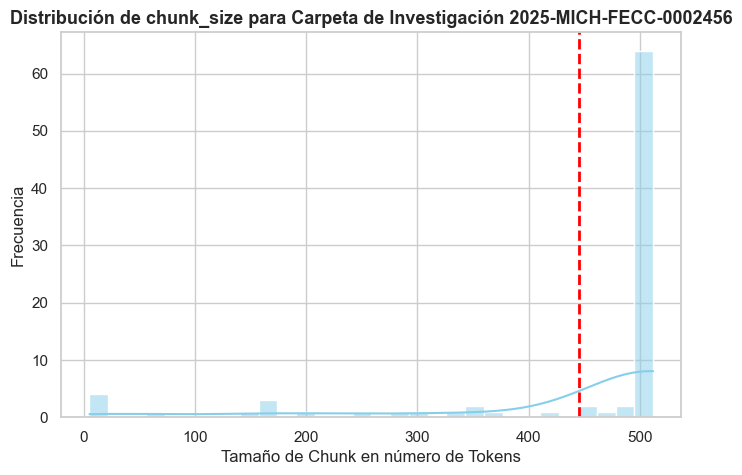

In [22]:
# Información del tamaño de chunks del DataFrame
for key, df in carpetas_chunks_dfs.items():
    plot_chunks(df, f"Carpeta de Investigación {key}")

In [23]:
# Procesamiento de metadatos de archivos de marco jurídico y vista previa

# 1) Generación de DataFrame chunks
marco_juridico_chunks_df = process_text_and_generate_chunks(marco_juridico_df, True)

# 2) Información general del DataFrame
marco_juridico_chunks_df.info()

100%|██████████| 24/24 [02:13<00:00,  5.56s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   doc_name    565 non-null    object
 1   text        565 non-null    object
 2   chunk_size  565 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 13.4+ KB


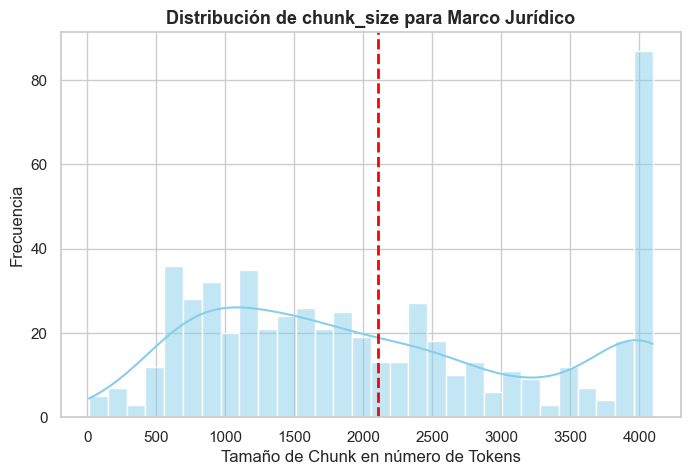

In [24]:
# Información del tamaño de chunks del DataFrame
plot_chunks(marco_juridico_chunks_df, "Marco Jurídico")

# 4. Generación de *Embeddings*

En el presente trabajo como se desarrolló en la sección del *preprocesamiento del corpus de texto*, se obtuvieron *chunks* de diferentes dimensiones en su ventana de contexto, es decir, de diferentes tamaños de caracteres. Esto último, como consecuencia de la lógica de su procesamiento, pues a los textos de **Carpetas de Investigación** al ser textos menos rígidos y un poco más homogéneos en su volumen, se procedió a generar *chunks* de un tamaño estándar tomando en cuenta un proceso de *overlaping* espacial para conservar contexto entre *chunks* adyacentes. Por su parte, los textos del **Marco Jurídico** al ser documentos más rígidos en su estructura, se procesaron mediante un *Chunking* basado en estructuras (artículos, capítulos, libros, etc.), lo cual al final produjo *chunks* que representaron estructuras completas, conservando el contexto, pero haciendo de estos segmentos muy variables en tamaño, aunque se hayan determinado límites mínimos y máximos de *tokens* con el mismo proceso de *overlapping* de los documentos de **Carpetas de Investigación**. En general para ambos tipos de documentos se utilizaron ventanas grandes con el objetivo de preservar el mayor contexto posible.

Para tener eficiencia en el uso de recursos, una uniformidad en el procesamiento de documentos sin importar su naturaleza y un mismo proceso de vectorización de *chunks* que pueden llegar a 4,096 *tokens*, se optó por el uso de un mismo modelo de *embeddings*.

El modelo que se seleccionó fue `e5-base-4k`, propuesto en el artículo llamado "*LongEmbed: Extending Embedding Models for Long Context Retrieval*". Este modelo está basado en *Absolute Position Embedding* (*APE*) que se erige como la estrategia de codificación posicional predominante para los modelos de *embeddings*. Los modelos basados ​​en *APE* primero embeben identificadores de posición absolutos en vectores de posición y añaden *embeddings* de tokens a sus vectores de posición correspondientes, antes de alimentarlos a una pila de capas de transformadores. En el artículo antes mencionado, los autores toman un modelo *APE* base de 512 posiciones y expanden la matriz de *embeddings* de posición para acomodar una mayor capacidad de tokens, y los vectores de *embeddings* están entrenados para representar un rango más amplio de identificadores de posición. `e5-base-4k` puede manejar entradas de hasta 4,096 *tokens*, lo que lo hace perfecto para tareas que requieren una comprensión más profunda del contexto (Zhu et al., 2024).

La elección de este modelo es beneficioso para este proyecto por que permite trabajar con ventanas más grandes a las normales, representa el estado del arte en en modelos de *embeddings* ajustados específicamente para tareas de Recuperación de Información (*Retrieval*), asegurando que los vectores generados para los chunks del **Marco Jurídico** y las **Carpetas de Investigación** sean de alta calidad y se encuentren en un espacio vectorial unificado y coherente.

Por otro lado, para garantizar que los *chunks* de gran tamaño, particularmente los provenientes del **Marco Jurídico**, puedan ser procesados eficientemente y sin pérdida de contexto (los *chunks* grandes pueden sufrir del problema de colapso de *embedding* o *embedding collapse* agruparse demasiado en el espacio vectorial), se implementa a continuación un mecanismo de **subchunks con ventana deslizante** (*sliding window*). Esta estrategia consiste en dividir cada *chunk* del corpus de texto en subfragmentos más manejables de longitud $L_{\text{sub}}$, con una superposición de (O) tokens entre *subchunks* consecutivos para preservar continuidad contextual:

$$\text{Subchunk}_i = \text{tokens}[i \cdot (L_{\text{sub}} - O) : i \cdot (L_{\text{sub}} - O) + L_{\text{sub}}]$$

De esta forma, cada fragmento conserva parte del contexto del *subchunk* anterior, evitando pérdidas de información en la generación de embeddings. Posteriormente, se generan los *embeddings* de cada *subchunk* mediante el modelo `e5-base-4k`, y estos se combinan en un único *embedding* representativo del *chunk* original. La combinación se realiza mediante **promedio ponderado por longitud de cada subchunk**, formalmente:

$$\mathbf{e}_{\text{final}} = \frac{\sum_{i=1}^{N} w_i \mathbf{e}_i}{\left|\sum_{i=1}^{N} w_i \mathbf{e}_i\right|_2}, \quad w_i = \frac{\text{len}(\text{subchunk}_i)}{\sum_{j=1}^{N} \text{len}(\text{subchunk}_j)}$$

Esta técnica está basada en la propuesta en el artículo llamado "*Late Chunking: Contextual Chunk Embeddings Using Long-Context Embedding Models*" (Gunther et al., 2025) y tiene varias implicaciones prácticas:

1. **Uniformidad en la representación:** Permite que todos los *chunks*, sin importar su tamaño original, se conviertan en vectores comparables.
2. **Preservación del contexto:** La superposición de tokens asegura que información crítica en los límites de *subchunks* no se pierda.
3. **Eficiencia computacional:** Se evita exceder el límite de *tokens* del modelo y se procesan fragmentos más pequeños en batches, optimizando el uso de memoria y GPU.
4. **Mejora en la recuperación semántica:** Los embeddings resultantes mantienen coherencia contextual y representan de manera más fiel la información de los textos largos.

En resumen, el uso de *subchunks* con ventana deslizante junto con la combinación de *embeddings* garantiza que la información textual compleja, especialmente de documentos legales extensos, sea adecuadamente capturada por el modelo `e5-base-4k` sin comprometer la eficiencia ni la calidad de los vectores generados.

In [25]:
# Bloque de inicialización del modelo E5-Base-4k

# 1) Definición del nombre del modelo y del dispositivo de cómputo
MODEL_NAME = 'dwzhu/e5-base-4k'                         # Nombre del modelo a cargar desde Hugging Face
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Selecciona GPU si está disponible, sino CPU

# 2) Carga del tokenizador y del modelo
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)           # Tokenizador preentrenado para E5
embed_model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)  # Modelo cargado en el dispositivo seleccionado

# 3) Configuración del modelo en modo evaluación para desactivar dropout y optimizaciones de entrenamiento
embed_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(4096, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [26]:
def normalize_chunks_for_e5(df, tokens_column='text'):
    """
    Convierte un DataFrame de chunks en una lista de strings
    preparada para el modelo E5-Base-4k, como "passage"

    Parámetros:
        df (pd.DataFrame)    : DataFrame que contiene los chunks.
        tokens_column (str)  : Nombre de la columna que contiene la lista de tokens.

    Retorno:
        list : Lista de strings, cada uno con el prefijo "passage: "
    """

    # 1) Validar que la columna existe
    if tokens_column not in df.columns:
        raise ValueError(f"La columna '{tokens_column}' no existe en el DataFrame")

    # 2) Concatenar tokens de cada fila en un string
    chunks_of_text = [' '.join(tokens) for tokens in df[tokens_column]]

    # 3) Agregar el prefijo requerido por E5
    texts_for_e5 = [f"passage: {text}" for text in chunks_of_text]

    return texts_for_e5

In [27]:
def average_pool(last_hidden_states, attention_mask):
    """
    Aplica un promedio ponderado (average pooling) sobre los estados ocultos
    de un modelo E5, teniendo en cuenta la máscara de atención para ignorar
    los tokens de padding.

    Parámetros:
        last_hidden_states (Tensor) : Tensor de forma [batch_size, seq_len, hidden_size]
                                      que contiene los embeddings de cada token.
        attention_mask (Tensor)     : Tensor de forma [batch_size, seq_len] donde los
                                      valores 1 indican tokens válidos y 0 tokens de padding.

    Retorno:
        Tensor : Embeddings promedio por secuencia de forma [batch_size, hidden_size].
    """

    # 1) Aplicar máscara para cero en posiciones de padding
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)  # Ceros en tokens no válidos

    # 2) Sumar los embeddings y dividir por el número de tokens válidos para obtener el promedio
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]                  # Pooling promedio

In [28]:
def get_position_ids(input_ids, max_original_positions=512, encode_max_length=4096):
    """
    Genera los IDs de posición para los tokens de entrada, ajustando la escala
    si la secuencia excede el límite original de posiciones del modelo.

    Parámetros:
        input_ids (Tensor)           : Tensor de tokens de forma [batch_size, seq_len].
        max_original_positions (int) : Número máximo de posiciones originales del modelo (default=512).
        encode_max_length (int)      : Longitud máxima de codificación que se desea soportar (default=4096).

    Retorno:
        Tensor : Tensor de IDs de posición expandido a la misma forma que input_ids.
    """

    # 1) Generar IDs de posición secuenciales
    position_ids = list(range(input_ids.size(1)))                 # Lista de 0 a seq_len-1

    # 2) Determinar factor de escalamiento si la secuencia es más larga que el límite original
    factor = max(encode_max_length // max_original_positions, 1)  # Factor mínimo de 1
    if input_ids.size(1) <= max_original_positions:               # Solo escalar si no supera límite original
        position_ids = [(pid * factor) for pid in position_ids]   # Multiplica cada ID por el factor

    # 3) Convertir a tensor y expandir para que coincida con la forma de input_ids
    position_ids = torch.tensor(position_ids, dtype=torch.long)   # Convertir lista a tensor
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids) # Expandir a [batch_size, seq_len]

    # 4) Retornar los IDs de posición listos para usar en el modelo
    return position_ids

In [29]:
def split_to_subchunks(text, max_tokens=512, overlap_tokens=128):
    """
    Divide un texto largo en subfragmentos más pequeños (subchunks) según un límite máximo
    de tokens, permitiendo una superposición parcial entre ellos para preservar el contexto.

    Parámetros:
        text (str)          : Texto completo que se desea dividir en subfragmentos.
        max_tokens (int)    : Número máximo de tokens permitidos por subfragmento (por defecto 512).
        overlap_tokens(int) : Cantidad de tokens que se solapan entre subfragmentos consecutivos (por defecto 128).

    Retorno:
        list[str] : Lista de subfragmentos de texto generados, listos para su posterior procesamiento.
    """

    # 1) Tokenización del texto completo sin truncamiento
    encoding = tokenizer(text, truncation=False, padding=False, return_tensors="pt")  # Convierte el texto en tokens
    input_ids = encoding["input_ids"][0].tolist()                                     # Obtiene la lista de IDs de tokens
    n = len(input_ids)                                                                # Número total de tokens del texto

    # 2) Si el texto no supera el límite máximo, retorna el texto original como único subfragmento
    if n <= max_tokens:                                                               # Verifica si el texto es corto
        return [text]                                                                 # Retorna lista con un solo elemento

    # 3) Inicialización de variables para crear subfragmentos
    subchunks = []                                                                    # Lista que almacenará los subfragmentos
    step = max_tokens - overlap_tokens                                                # Paso con superposición entre subfragmentos

    # 4) Iteración sobre los tokens para generar subfragmentos
    for start in range(0, n, step):                                                   # Recorre los tokens con el paso definido
        end = start + max_tokens                                                      # Define el límite superior del subfragmento
        sub_ids = input_ids[start:end]                                                # Extrae los IDs correspondientes al subfragmento

        # 5) Decodificación de los tokens a texto legible
        sub_text = tokenizer.decode(sub_ids, skip_special_tokens=True)                # Convierte los tokens en texto
        subchunks.append(sub_text)                                                    # Agrega el subfragmento a la lista

        # 6) Finaliza el ciclo si se alcanza el final del texto
        if end >= n:                                                                  # Verifica si se llegó al final
            break

    # 7) Retorno de los subfragmentos generados
    return subchunks

In [30]:
def embed_subchunks(embed_model, sub_texts, batch_size=8):
    """
    Genera embeddings para una lista de subfragmentos de texto utilizando un modelo de lenguaje
    pasado como argumento. Los embeddings se normalizan y se procesan en batches para mayor eficiencia.

    Parámetros:
        embed_model (torch.nn.Module) : Modelo de lenguaje usado para generar los embeddings.
        sub_texts (list[str])         : Lista de subfragmentos de texto a convertir en embeddings.
        batch_size (int)              : Tamaño de lote para procesamiento en batches (por defecto 8).

    Retorno:
        np.ndarray : Array de embeddings normalizados, uno por cada subfragmento de texto.
    """

    # 1) Inicialización de la lista de embeddings
    emb_list = []

    # 2) Procesamiento de los subfragmentos por batches
    for i in range(0, len(sub_texts), batch_size):              # Itera en pasos del tamaño de batch
        batch = sub_texts[i : i + batch_size]                   # Extrae el batch actual
        enc = tokenizer(batch,                                  # Tokeniza el batch
                        padding=True,
                        truncation=True,
                        max_length=4096,
                        return_tensors="pt")
        enc = {k: v.to(DEVICE) for k, v in enc.items()}         # Mueve tensores al dispositivo adecuado (CPU/GPU)

        # 3) Generación de embeddings sin calcular gradientes
        with torch.no_grad():
            out = embed_model(**enc)                            # Obtiene la salida del modelo

        # 4) Extracción del último estado oculto y cálculo del embedding promedio
        last_hidden = out.last_hidden_state                     # Obtiene la representación de cada token
        emb = average_pool(last_hidden, enc["attention_mask"])  # Promedia sobre los tokens usando la máscara de atención

        # 5) Normalización L2 de los embeddings
        emb = F.normalize(emb, p=2, dim=1)                      # Normaliza cada embedding a longitud 1
        emb_list.append(emb.cpu().numpy())                      # Mueve a CPU y agrega a la lista

    # 6) Manejo de caso donde no se generaron embeddings
    if len(emb_list) == 0:                                      # Verifica lista vacía
        return np.zeros((0, embed_model.config.hidden_size))    # Retorna array vacío con tamaño adecuado

    # 7) Concatenación final de todos los embeddings en un solo array
    return np.vstack(emb_list)

In [31]:
def combine_subchunk_embeddings(embeddings, sub_texts):
    """
    Combina los embeddings de subfragmentos de texto en un único embedding representativo
    del texto completo, utilizando promedio, máximo y ponderación por longitud de subfragmento.

    Parámetros:
        embeddings (np.ndarray) : Array de embeddings de los subfragmentos (num_subchunks x dim_embedding).
        sub_texts (list[str])   : Lista de subfragmentos de texto correspondientes a los embeddings.

    Retorno:
        np.ndarray : Embedding combinado y normalizado del texto completo.
    """

    # 1) Manejo de caso con embeddings vacíos
    if embeddings.shape[0] == 0:                # Si no hay embeddings
        return np.zeros((embeddings.shape[1],)) # Retorna vector de ceros con la dimensión del embedding

    # 2) Cálculo de embedding promedio
    emb_mean = embeddings.mean(axis=0)

    # 3) Cálculo de embedding máximo
    emb_max = embeddings.max(axis=0)

    # 4) Cálculo de embedding ponderado por longitud de subchunk
    lengths = [ len(tokenizer(txt, truncation=True)["input_ids"]) for txt in sub_texts ]  # Longitud de tokens de cada subchunk
    lengths = np.array(lengths, dtype=float)                                              # Convierte a array float
    if lengths.sum() > 0:                                                                 # Si hay longitud total positiva
        w = lengths / lengths.sum()                                                       # Calcula pesos proporcionales a la longitud
        emb_weighted = np.sum(embeddings * w[:, None], axis=0)                            # Embedding ponderado por longitud
    else:
        emb_weighted = emb_mean                                                           # Si no hay tokens, usa promedio

    # 5) Selección del embedding final
    final = emb_weighted

    # 6) Normalización del embedding final
    final = final / np.linalg.norm(final) if np.linalg.norm(final) > 0 else final         # Normaliza si norma > 0

    # 7) Retorno del embedding combinado y normalizado
    return final

In [32]:
def generate_embeddings(embed_model, input_data, batch_size=32, use_subchunks=True,
                        max_tokens=512, overlap_tokens=128):
    """
    Genera embeddings para un texto o un DataFrame de textos utilizando un modelo de lenguaje.
    Permite dividir textos largos en subchunks para mejorar la representación y normaliza los embeddings.

    Parámetros:
        embed_model (torch.nn.Module) : Modelo de lenguaje para generar embeddings.
        input_data (str o pd.DataFrame) : Texto único o DataFrame con textos a procesar.
        batch_size (int) : Tamaño de batch para procesamiento (por defecto 32).
        use_subchunks (bool) : Indica si se deben dividir los textos largos en subchunks (por defecto True).
        max_tokens (int) : Máximo número de tokens por subchunk (por defecto 512).
        overlap_tokens (int) : Número de tokens superpuestos entre subchunks consecutivos (por defecto 128).

    Retorno:
        pd.DataFrame : DataFrame con los embeddings generados, un embedding por fila.
    """

    # 1) Normalización del input según tipo
    if isinstance(input_data, str):
        if not input_data.strip():                                  # Valida que el texto no esté vacío
            raise ValueError("El texto proporcionado está vacío.")
        chunk_texts = [f"passage: {input_data.strip()}"]            # Convierte el texto en lista
    elif isinstance(input_data, pd.DataFrame):
        if input_data.empty:                                        # Valida que el DataFrame no esté vacío
            raise ValueError("El DataFrame está vacío.")
        chunk_texts = normalize_chunks_for_e5(input_data)           # Normaliza textos del DataFrame
    else:
        raise ValueError("El input debe ser un DataFrame o una cadena de texto.")  # Tipo inválido

    # 2) Inicialización de lista de embeddings
    embeddings = []

    # 3) Procesamiento de textos por batches
    for i in tqdm(range(0, len(chunk_texts), batch_size), desc="Generando embeddings"): # Itera por batches
        batch_texts = chunk_texts[i:i + batch_size]                                     # Extrae batch actual
        batch_embeddings = []                                                           # Lista para embeddings del batch

        # 4) Generación de embeddings por texto dentro del batch
        for text in batch_texts:
            if use_subchunks:                                                                               # Si se usan subchunks
                sub_texts = split_to_subchunks(text, max_tokens=max_tokens, overlap_tokens=overlap_tokens)  # Divide en subchunks
                if len(sub_texts) == 1:                                                                     # Caso de un solo subchunk
                    batch_dict = tokenizer(sub_texts,
                                           max_length=4096,
                                           padding=True,
                                           truncation=True,
                                           return_tensors='pt').to(DEVICE)
                    with torch.no_grad():                                                       # Sin gradientes para eficiencia
                        outputs = embed_model(**batch_dict)
                    emb = average_pool(outputs.last_hidden_state, batch_dict['attention_mask']) # Pooling promedio
                    emb = F.normalize(emb, p=2, dim=1)                                          # Normalización L2
                    final_emb = emb[0].cpu().numpy()                                            # Extrae el embedding final
                else:                                                                           # Caso de múltiples subchunks
                    sub_embs = embed_subchunks(embed_model, sub_texts, batch_size=batch_size)   # Embeddings de subchunks
                    final_emb = combine_subchunk_embeddings(sub_embs, sub_texts)                # Combina embeddings en uno solo
            else:                                                                               # Si no se usan subchunks
                batch_dict = tokenizer([text],
                                       max_length=4096,
                                       padding=True,
                                       truncation=True,
                                       return_tensors='pt').to(DEVICE)
                with torch.no_grad():
                    outputs = embed_model(**batch_dict)
                emb = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
                emb = F.normalize(emb, p=2, dim=1)
                final_emb = emb[0].cpu().numpy()

            # 5) Agrega embedding final del texto al batch
            batch_embeddings.append(final_emb)

        # 6) Extiende lista principal de embeddings con embeddings del batch
        embeddings.extend(batch_embeddings)

    # 7) Conversión de embeddings a DataFrame
    embeddings_df = pd.DataFrame(np.array(embeddings))  # Crea DataFrame con cada embedding en una fila

    # 8) Retorno del DataFrame con embeddings
    return embeddings_df

In [33]:
# Bloque de generación y visualización de embeddings

# 1) Generación de embeddings para los chunks de carpetas con batch size de 64
carpetas_embeddings_dfs = {
    key: generate_embeddings(embed_model, value, batch_size=64)
    for key, value in carpetas_chunks_dfs.items()
}

# 2) Mostrar las primeras filas del DataFrame de embeddings para inspección rápida
for key, df in carpetas_embeddings_dfs.items():
    print(f"\n=== Embeddings de Carpeta de Investigación: {key} ===\n")
    display(df.head())

Generando embeddings: 100%|██████████| 2/2 [00:46<00:00, 23.07s/it]


=== Embeddings de Carpeta de Investigación: 2025-MICH-FECC-0001789 ===



,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.000249,-0.009296,-0.048207,-0.014559,0.053053,-0.027073,0.017226,0.027067,0.001500,-0.039055,...,0.040340,-0.027402,0.046278,-0.027970,0.049552,-0.022003,-0.068813,0.008128,0.029817,0.079553
1,-0.001593,-0.014359,-0.045014,-0.028182,0.047396,-0.033138,0.016580,0.026849,0.004611,-0.031547,...,0.032543,-0.026586,0.049669,-0.021459,0.049092,-0.019866,-0.071146,0.001714,0.030846,0.075570
2,0.000837,-0.009555,-0.047215,-0.027227,0.049847,-0.030394,0.018452,0.032874,-0.002040,-0.036987,...,0.030342,-0.030974,0.050675,-0.021859,0.045622,-0.017491,-0.070435,0.003897,0.036027,0.079107
3,-0.005639,-0.008346,-0.053726,-0.017921,0.053114,-0.033069,0.014264,0.025855,0.006585,-0.037058,...,0.043069,-0.028015,0.051059,-0.028223,0.048450,-0.015041,-0.071200,0.008560,0.033053,0.082822
4,0.000597,-0.011046,-0.042484,-0.020858,0.048709,-0.034422,0.016691,0.031514,0.006067,-0.029509,...,0.024758,-0.028647,0.053690,-0.014970,0.047886,-0.019630,-0.067822,0.007086,0.034272,0.070234



=== Embeddings de Carpeta de Investigación: 2025-MICH-FECC-0002456 ===



,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.002859,-0.010544,-0.040965,-0.016866,0.053646,-0.026990,0.019082,0.023131,-0.004318,-0.029914,...,0.037012,-0.020191,0.046264,-0.027023,0.049987,-0.025398,-0.071810,0.004675,0.032258,0.075618
1,0.003689,-0.006197,-0.044995,-0.022717,0.055593,-0.027429,0.010993,0.027863,-0.012359,-0.033493,...,0.032281,-0.022378,0.049709,-0.022466,0.046486,-0.018758,-0.070983,0.000282,0.032558,0.076376
2,-0.005368,-0.016125,-0.048339,-0.027298,0.046248,-0.035152,0.013597,0.025811,0.002033,-0.036765,...,0.037700,-0.028654,0.052279,-0.019636,0.046393,-0.013478,-0.068847,0.010107,0.026490,0.073086
3,0.001251,-0.004173,-0.046173,-0.021715,0.044877,-0.035344,0.021456,0.023589,0.005984,-0.032954,...,0.026276,-0.027906,0.047228,-0.019740,0.047061,-0.011699,-0.068920,0.011151,0.027423,0.074362
4,0.002258,-0.006825,-0.048969,-0.018554,0.051720,-0.036149,0.016001,0.029167,-0.004672,-0.031383,...,0.039016,-0.018774,0.055475,-0.020246,0.052710,-0.023888,-0.071075,0.005068,0.028821,0.078796


In [34]:
# Información general del DataFrame
for key, df in carpetas_embeddings_dfs.items():
    print(f"\n=== Información de los Embeddings de Carpeta de Investigación: {key} ===\n")
    display(df.info())


=== Información de los Embeddings de Carpeta de Investigación: 2025-MICH-FECC-0001789 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Columns: 768 entries, 0 to 767
dtypes: float64(768)
memory usage: 558.1 KB


None


=== Información de los Embeddings de Carpeta de Investigación: 2025-MICH-FECC-0002456 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Columns: 768 entries, 0 to 767
dtypes: float64(768)
memory usage: 522.1 KB


None

In [35]:
# Bloque de generación y visualización de embeddings

# 1) Generación de embeddings para los chunks de carpetas con batch size de 16
marco_juridico_embeddings_df = generate_embeddings(embed_model, marco_juridico_chunks_df, batch_size=16)

# 2) Mostrar las primeras filas del DataFrame de embeddings para inspección rápida
marco_juridico_embeddings_df.head()

Generando embeddings: 100%|██████████| 36/36 [21:29<00:00, 35.82s/it]


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.005199,-0.016698,-0.045691,-0.026663,0.049016,-0.033477,0.013983,0.031937,0.000468,-0.035381,...,0.032125,-0.029822,0.054135,-0.018269,0.045897,-0.020441,-0.069231,0.006762,0.032779,0.069459
1,-0.006199,-0.015524,-0.043512,-0.026884,0.048143,-0.034899,0.014968,0.027552,0.004228,-0.036024,...,0.030985,-0.031349,0.053264,-0.018857,0.046218,-0.016719,-0.069179,0.007653,0.030582,0.068847
2,-0.006862,-0.015269,-0.044130,-0.024239,0.051213,-0.035162,0.014744,0.031993,-0.000976,-0.035330,...,0.031576,-0.033239,0.054010,-0.017912,0.043514,-0.019537,-0.068977,0.005103,0.034284,0.072674
3,-0.003788,-0.011018,-0.049983,-0.025171,0.049114,-0.028578,0.013480,0.025835,-0.001531,-0.037601,...,0.033675,-0.024613,0.048641,-0.022576,0.048832,-0.022697,-0.070593,0.008179,0.032336,0.075415
4,-0.004355,-0.010795,-0.049531,-0.022984,0.049827,-0.029128,0.012151,0.028330,-0.001043,-0.037349,...,0.035513,-0.025463,0.049969,-0.025646,0.049182,-0.020082,-0.069821,0.008612,0.033196,0.074711


In [36]:
# Información general del DataFrame
marco_juridico_embeddings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Columns: 768 entries, 0 to 767
dtypes: float64(768)
memory usage: 3.3 MB


# 5. Modelo Baseline

## 5.1. Algoritmo

En la presente sección, se justifica la elección de un algoritmo o modelo *Basile* que se integre al presente proyecto. Así pues, la solución que se implementará propone el desarrollo de un sistema ***RAG*** que contempla la integración de un modelo ***LLM*** y de un motor de **Base de Datos Vectorial**.

En primer lugar, los ***Large Language Models*** o ***LLMs*** son arquitecturas poderosas basadas en *Transformers*, entrenadas con objetivos genéricos de modelado de lenguaje (por ejemplo, predicción de palabra siguiente). Como lo señalan Loo et al. (2026), estos modelos capturan patrones lingüísticos amplios, pero carecen muchas veces del conocimiento específico y actualizado necesario para dominios como el jurídico.

Para superar esa limitación, el paradigma de ***Retrieval-Augmented Generation*** o ***RAG*** propone una simbiosis entre recuperación de información y generación de lenguaje (Aytar et al., 2025). En esencia, un modelo ***RAG*** permite que un ***LLM*** busque fragmentos relevantes de un corpus externo (por medio de un mecanismo de recuperación semántica) y los incorpore como contexto para producir una respuesta más informada, precisa y fundamentada. En muchas industrias como la legal, esta integración ha probado su valor al mejorar respuestas especializadas que un ***LLM*** sin contexto fallaría en responder correctamente.

Un sistema RAG típico opera en tres fases (Gao et al., 2024):
  1. **Indexación**: los documentos (o fragmentos textuales) se dividen en *chunks*, se transforman en vectores (*embeddings*) y se almacenan en una base de datos vectorial.
  2. **Recuperación**: ante una consulta, el sistema busca los *k* fragmentos más similares semánticamente.
  3. **Generación**: la pregunta original junto con esos fragmentos recuperados se alimentan al modelo de lenguaje, que genera la respuesta final.

Así pues, tanto para esta propuesta de *Baseline* como para el desarrollo de todo el trabajo, la **Base de Datos Vectorial** seleccionada es **Qdrant**, derivado de su flexibilidad al poderse utilizar tanto de manera local, en microservicios o en la nube. Por otra parte, existe mucha diferencia entre los mecanismos usados por **Qdrant** y otros proveedores en el mercado.

**Qdrant** es un motor de búsqueda vectorial de alto rendimiento y base de datos especializada para vectores de alta dimensión, escrita en *Rus*t, optimizada para manejar búsquedas semánticas con eficiencia y escalabilidad. Ofrece una *API* ligera para almacenar vectores y su metadata, y soporta métricas de distancia esenciales como **Cosine**, **Dot Product** y euclidea. Su diseño lo hace ideal como centro del componente *retriever* de un sistema ***RAG***, pues se adapta bien a esquemas de producción, escala bien y es relativamente sencillo de desplegar (Qdrant, 2023).

Para el modelo ***LLM*** en esta sección de *Baseline* se utilizará **Gemma-2-2B-IT** (modelo `google/gemma-2-2b-it` disponible en Hugging Face). Este modelo, desarrollado por Google, pertenece a la familia **Gemma**, diseñada para ofrecer capacidades de lenguaje natural avanzadas en un formato relativamente compacto (2 mil millones de parámetros). Se trata de un modelo *instruction-tuned* (ajustado mediante instrucciones), lo que le permite seguir indicaciones de manera más controlada y coherente. Su elección obedece a razones prácticas: ofrece un equilibrio entre rendimiento y eficiencia computacional, puede ejecutarse en entornos locales con recursos moderados y resulta adecuado como punto de partida para establecer una línea base de generación de texto contextual y jurídicamente relevante. Con **Gemma-2-2B-IT**, no se busca alcanzar la máxima precisión semántica o argumentativa, sino definir una referencia funcional que permita comparar su desempeño frente a modelos más grandes y especializados en etapas posteriores, empleando métricas que se analizarán más adelante (Hugging Face, 2024).

Así, el algoritmo baseline combina:
  - Un **componente de recuperación** basado en ***Qdrant*** + *embeddings*,
  - Un **codificador cruzado** para refinar la recuperación de documentos, basado en el modelo **MS-Marco-MiniLM-L6-V2**.
  - Un **componente generativo** ligero con **Gemma-2-2B-IT**,
  - Y una estrategia ***RAG*** que conecta ambos para producir respuestas más contextualizadas de lo que el modelo por sí solo podría lograr.

### a) Base de Datos Vectorial

In [37]:
# Construcción del diccionario principal de colecciones con embeddings y textos
collections = {
    "marco_juridico": {
        "embeddings": marco_juridico_embeddings_df.values.tolist(),     # Conversión de embeddings del marco jurídico a lista
        "text": marco_juridico_chunks_df["text"].values.tolist(),       # Lista de textos correspondientes
        "doc": marco_juridico_chunks_df["doc_name"].values.tolist()          # Lista de documentos de origen
    },
    **{
        key: {
            "embeddings": carpetas_embeddings_dfs[key].values.tolist(), # Embeddings de cada carpeta individual
            "text": carpetas_chunks_dfs[key]["text"].values.tolist(),   # Textos chunkificados por carpeta
            "doc": carpetas_chunks_dfs[key]["doc_name"].values.tolist()      # Documentos originales asociados
        }
        for key in carpetas_embeddings_dfs.keys()                       # Iteración sobre todas las carpetas con embeddings
    }
}

In [38]:
def init_vector_db(collections):
    """
    Inicializa una base de datos vectorial en memoria usando Qdrant e ingresa las colecciones proporcionadas.

    Parámetros:
        collections (dict) : Diccionario que contiene las colecciones de embeddings, textos y documentos,
                            con la siguiente estructura:
                            {"nombre_coleccion": {"embeddings": [...], "text": [...], "doc": [...]}}

    Retorno:
        QdrantClient | None : Instancia del cliente Qdrant con las colecciones cargadas,
                              o None si ocurre un error en la conexión o configuración.
    """

    # 1) Intentar establecer la conexión con Qdrant en memoria
    try:
        vector_db = QdrantClient(":memory:")                      # Se crea una instancia del cliente Qdrant en memoria
        print(f"Conectado correctamente a Qdrant.")
    except Exception as e:
        print(f"No se pudo conectar a Qdrant: {e}")
        return None                                               # Retorna None si la conexión falla

    # 2) Crear colecciones y subir sus embeddings
    for name, data in collections.items():                        # Iteración sobre cada colección del diccionario
        try:
            vector_db.create_collection(                        # Recrear o crear una colección desde cero
                collection_name=name,
                vectors_config=models.VectorParams(
                    size=768,                                     # Dimensión del embedding (tamaño fijo del modelo)
                    distance=models.Distance.COSINE               # Métrica de similitud basada en el coseno
                )
            )
            print(f"Colección '{name}' creada correctamente.")
        except Exception as e:
            print(f"No se pudo crear la colección '{name}': {e}")
            continue                                              # Se continúa con la siguiente colección

        # 3) Subida de los embeddings y metadatos asociados
        try:
            embeddings = data["embeddings"]                       # Recuperar embeddings de la colección
            payload = [
                {"text": text, "doc": doc}                        # Se asocia cada vector con su texto y documento
                for text, doc in zip(data["text"], data["doc"])
            ]

            vector_db.upload_collection(                          # Subida masiva de vectores a la colección
                collection_name=name,
                vectors=embeddings,
                payload=payload,
                ids=list(range(len(embeddings)))                  # IDs secuenciales para cada vector
            )
        except Exception as e:
            print(f"Error subiendo vectores a '{name}': {e}")     # Manejo de error en la carga de vectores

    # 4) Confirmación final del pro
    print("\nVector DB generada correctamente.")                  # Mensaje final de éxito
    return vector_db                                              # Retorna la instancia de la base de datos vectorial

In [39]:
# Inicialización de la base de datos vectorial
vector_db = init_vector_db(collections)

Conectado correctamente a Qdrant.
Colección 'marco_juridico' creada correctamente.
Colección '2025-MICH-FECC-0001789' creada correctamente.
Colección '2025-MICH-FECC-0002456' creada correctamente.

Vector DB generada correctamente.


### b) Large Language Models (*LLM*)

In [40]:
def init_llm_model(model_name):
    """
    Inicializa un modelo de lenguaje grande (LLM) para generación de texto usando Hugging Face.

    Parámetros:
        model_name (str) : Nombre o ruta del modelo a cargar (por ejemplo, "gpt2").

    Retorno:
        pipeline o None : Retorna un pipeline de Hugging Face configurado para generación de texto.
                          Si ocurre un error durante la carga, retorna None.
    """

    # 1) Intento de inicialización del modelo
    try:
        print(f"Cargando modelo LLM '{model_name}'.")

        # 2) Carga del tokenizer del modelo
        tokenizer = AutoTokenizer.from_pretrained(model_name)     # Tokenizador necesario para procesar texto

        # 3) Carga del modelo de lenguaje para generación causal
        model = AutoModelForCausalLM.from_pretrained(model_name)  # Modelo principal para generación de texto

        # 4) Creación del pipeline de generación de texto
        llm_model = pipeline(
            task="text-generation",                               # Define que el pipeline realizará generación de texto
            model=model,                                          # Modelo previamente cargado
            tokenizer=tokenizer,                                  # Tokenizador previamente cargado
            device_map="auto"                                     # Asigna automáticamente el dispositivo (CPU/GPU)
        )

        print(f"Modelo '{model_name}' cargado correctamente.")
        return llm_model                                          # Retorna el pipeline listo para usar

    # 5) Manejo de errores durante la inicialización
    except Exception as e:
        print(f"Error al inicializar el modelo LLM '{model_name}': {e}.")
        return None                                               # Retorna None si ocurre algún fallo

In [41]:
# Inicialización del modelo LLM
llm_model = init_llm_model("google/gemma-2-2b-it")

Cargando modelo LLM 'google/gemma-2-2b-it'.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use mps:0


Modelo 'google/gemma-2-2b-it' cargado correctamente.


### c) Configuración Sistema *RAG*

In [42]:
def vector_db_retriever(query, collection, embed_model, vector_db, top_k=25):
    """
    Recupera los puntos más relevantes de una base de datos vectorial dado un query textual.

    Parámetros:
        query (str)                   : Texto de consulta para buscar en la base de vectores.
        collection (str)              : Nombre de la colección dentro de la base de datos vectorial.
        embed_model (torch.nn.Module) : Modelo de lenguaje para generar embeddings.
        vector_db (objeto)            : Instancia de la base de datos vectorial (ej., Qdrant client).
        top_k (int, opcional)         : Número máximo de resultados a recuperar (por defecto 5).

    Retorno:
        list : Lista de diccionarios con la información de los resultados, cada uno contiene:
               "id"    : Identificador del punto,
               "score" : Puntuación de similitud,
               "text"  : Texto asociado,
               "doc"   : Documento o fuente del embedding.
    """

    # 1) Generación del embedding de la consulta
    embedded_query = generate_embeddings(embed_model, query, use_subchunks=False)

    query_vector = embedded_query.iloc[0].tolist()  # Extracción de lista de embeddings

    # 2) Consulta a la base de datos vectorial
    results = vector_db.query_points(
        collection_name=collection,       # Colección donde se realizará la búsqueda
        query=query_vector,               # Vector de la consulta
        limit=top_k,                      # Número máximo de resultados
        with_payload=True,                # Incluir la información adicional (payload) de cada punto
    )

    # 3) Procesamiento de resultados y extracción de información
    retrieved_data = []                   # Lista donde se almacenarán los resultados formateados

    for r in results.points:
        try:
            payload = r.payload           # Información adicional del punto
            id_ = r.id                    # ID del punto
            score = r.score               # Puntuación de similitud
        except AttributeError:
            print(f"Advertencia: Resultado con formato inesperado: {r}")
            continue

        # 4) Extracción de campos específicos del payload
        text = payload.get("text", "N/A") # Texto asociado, si no existe asigna "N/A"
        doc = payload.get("doc", "N/A")   # Documento o fuente asociada, si no existe asigna "N/A"

        # 5) Agregando el resultado a la lista final
        retrieved_data.append({
            "id": id_,
            "score": score,
            "text": text,
            "doc": doc
        })

    # 6) Retorno de los datos recuperados
    return retrieved_data

In [43]:
def generate_llm_response(llm_model, query, context_docs, max_new_tokens=256, temperature=0.7):
    """
    Genera una respuesta utilizando un modelo LLM basado en un conjunto de documentos de contexto.

    Parámetros:
        llm_model (pipeline)  : Pipeline de Hugging Face para generación de texto.
        query (str)           : Pregunta o consulta del usuario.
        context_docs (list)   : Lista de textos que conforman el contexto para la respuesta.
        max_new_tokens (int)  : Máximo número de tokens a generar en la respuesta (por defecto 200).
        temperature (float)   : Controla la creatividad del modelo (por defecto 0.7).

    Retorno:
        str : Respuesta generada por el modelo basada en el contexto proporcionado.
    """

    # 1) Preparación del contexto concatenado
    context_text = "\n\n".join(context_docs)    # Une todos los documentos con saltos

    # 2) Creación del prompt para el modelo LLM
    prompt = f"""
    Eres un **Asistente Legal Experto** especializado en el análisis de documentos y marcos normativos. Tu objetivo es responder a la pregunta del usuario utilizando la información proporcionada en el Contexto.

    **Reglas de Respuesta:**
    1. Responde a la pregunta tomando como base al contexto, pero sin limitarte a este (puedes argumentar más allá del contexto no te limítes).
    2. Incluye **citas directas** o referencias al documento original (si está disponible en el Contexto).

    --- CONTEXTO ---
    {context_text}

    --- PREGUNTA ---
    {query}

    --- RESPUESTA ---
    """

    # 3) Generación de la respuesta con el modelo LLM
    result = llm_model(
        prompt,
        max_new_tokens=max_new_tokens,                # Limita la longitud de la respuesta
        temperature=temperature,                      # Controla la creatividad del texto generado
        do_sample=True,                               # Permite muestreo para generación de texto
        pad_token_id=llm_model.tokenizer.eos_token_id # Evita errores de padding
    )[0]["generated_text"]                            # Obtiene el texto generado completo

    # 4) Extracción de la parte de la respuesta después de "Respuesta:"
    response = result.split("Respuesta:")[-1].strip()

    # 5) Retorno de la respuesta final
    return response

In [44]:
def run_llm_query(query, collection_name, vector_db, llm_model, top_k=25):
    """
    Ejecuta una consulta a un modelo LLM utilizando documentos recuperados de una base de datos vectorial.

    Parámetros:
        query (str)                   : Pregunta o consulta del usuario.
        collection_name (str)         : Nombre de la colección en la base de datos vectorial.
        vector_db (objeto)            : Instancia de la base de datos vectorial (ej., Qdrant client).
        llm_model (pipeline)          : Pipeline de Hugging Face para generación de texto.
        top_k (int, opcional)         : Número máximo de documentos a recuperar para contexto (por defecto 5).

    Retorno:
        None : Imprime en consola los documentos recuperados y la respuesta generada por el modelo.
    """
    # 1) Validación de la consulta
    if not query.strip():
        print("\nError: la consulta está vacía.")
        return

    print(f"\n=== Consulta ===\n")
    print(query)
    print(f"\n=== Colección ===\n")
    print(collection_name)

    # 2) Recuperación de documentos relevantes desde la base de datos vectorial
    try:
        retrieved_data = vector_db_retriever(query, collection_name, embed_model, vector_db, top_k=top_k)  # Llama al retriever
        if not retrieved_data:
            print("\nNo se encontraron documentos relevantes.")
            return
    except Exception as e:
        print(f"\nError al recuperar documentos: {e}")
        return

    # 3) Presentación de los documentos recuperados
    print("\n\n=== Documentos recuperados === \n")
    for item in retrieved_data:
        print("--------------------------------------------------")
        print(f"ID del Chunk: {item['id']} | Score: {item['score']:.4f} | Documento: {item['doc']}")
        print(f"Texto:\n{item['text'][:100]}\n")

    # 4) Preparación del contexto para el modelo LLM
    context_docs = [item["text"] for item in retrieved_data]

    # 5) Generación de la respuesta usando LLM
    try:
        response = generate_llm_response(llm_model, query, context_docs)  # Genera la respuesta basada en el contexto
        print("\n\n=== Respuesta del modelo ===\n")
        print(response)
    except Exception as e:
        print(f"\nError al generar la respuesta: {e}")

In [45]:
# Ejecución de consulta LLM sobre la colección jurídica

# 1) Definición de la consulta
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""

# 2) Selección de la colección
collection_name = "marco_juridico"

# 3) Ejecución de la consulta con LLM
run_llm_query(query, collection_name, vector_db, llm_model, top_k=5)


=== Consulta ===

Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal.

=== Colección ===

marco_juridico


Generando embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]




=== Documentos recuperados === 

--------------------------------------------------
ID del Chunk: 206 | Score: 0.7820 | Documento: corte_interamericana_de_derechos_humanos_caso_mujeres_victimas_de_tortura_sexual_en_atenco_vs_mexico
Texto:
artículo 5 ) . onu , asamblea general , responsabilidad del estado por

--------------------------------------------------
ID del Chunk: 79 | Score: 0.7684 | Documento: jurisprudencia_responsabilidades_administrativas
Texto:
justificación : dado que el derecho a los recursos , salvo en materia penal , no es absoluto , la ex

--------------------------------------------------
ID del Chunk: 563 | Score: 0.7654 | Documento: jurisprudencia_corrupcion
Texto:
criterio jurídico : para cuantificar el monto de la condena por daño moral , las personas juzgadoras

--------------------------------------------------
ID del Chunk: 299 | Score: 0.7617 | Documento: corte_interamericana_de_derechos_humanos_caso_garcia_rodriguez_y_otro_vs_mexico
Texto:
hechos de tort

## 5.2. Características Importantes

En este sistema RAG, se utiliza ***Cosine Similarity*** como medida de similitud entre *embeddings*. La medida de similitud coseno o ***Cosine Similarity*** (***CSM***) es una métrica para calcular la similitud de dos vectores en un espacio multidimensional. Se calcula como el coseno del ángulo entre dos vectores. ***CSM*** es ampliamente utilizada en muchos campos, incluyendo la recuperación de información, el procesamiento del lenguaje natural y la minería de datos, para determinar la similitud de materiales, textos o puntos de datos (Rahim et al., 2024). La formula es:

$$\text{Similitud Coseno}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}$$

Esta fórmula calcula el coseno del ángulo entre dos vectores, $\mathbf{A}$ y $\mathbf{B}$, en un espacio *$n$-dimensional*:

  - **Numerador ($\mathbf{A} \cdot \mathbf{B}$):** Representa el **producto punto** (dot product) de los vectores $\mathbf{A}$ y $\mathbf{B}$.
  - **Denominador ($\|\mathbf{A}\| \|\mathbf{B}\|$):** Es el producto de las **magnitudes** (o norma euclidiana) de los vectores $\mathbf{A}$ y $\mathbf{B}$.

El resultado siempre estará entre **-1** (perfectamente opuestos) y **1** (perfectamente iguales), donde un valor de **1** indica máxima similitud temática.

Otras métricas posibles serían dot product (producto punto) o distancia euclidiana, pero estas suelen ser más sensibles a la magnitud de los vectores. En *embeddings* semánticos, como es el caso de este trabajo, donde la dirección codifica significado y no la longitud, Cosine Similarity es la opción más robusta y ampliamente utilizada en sistemas RAG.

De esta manera, a continuación, se implementa una visualización exploratoria de los *embeddings* jurídicos con el fin de analizar su distribución semántica en el espacio vectorial. Para ello, se aplica una técnica de reducción de dimensionalidad denominada ***Principal Component Analysis*** (***PCA***), que permite proyectar los vectores de alta dimensión en un plano bidimensional, preservando la mayor cantidad posible de la varianza original.

Esta visualización tiene como objetivo analizar la **disposición espacial** de los *embeddings* pertenecientes a distintas colecciones documentales. Cada punto del gráfico representa un *embedding* asociado a un fragmento textual, mientras que los colores indican su colección de origen. La proximidad entre puntos dentro del espacio vectorial refleja una **mayor similitud semántica**, lo que permite verificar que los documentos con contenido temático relacionado tienden a agruparse de forma natural. En este contexto, la métrica de ***Cosine Similarity (CSM)*** resulta especialmente adecuada, ya que captura de manera efectiva las relaciones semánticas entre vectores, favoreciendo una recuperación de información más precisa y coherente.

In [46]:
def plot_embeddings_pca(collections):
    """
    Visualiza embeddings de diferentes colecciones utilizando PCA para reducción a 2 dimensiones.

    Parámetros:
        collections (dict) : Diccionario donde la clave es el nombre de la colección y el valor
                             es una lista o array de embeddings asociados a esa colección.

    Retorno:
        None : Muestra un gráfico de dispersión (scatter plot) de los embeddings reducidos.
    """

    # 1) Concatenación de todos los embeddings en un solo array
    all_embeddings = np.vstack([
        np.array(col["embeddings"])
        for key, col in collections.items()
    ])

    # 2) Generación de etiquetas correspondientes a cada embedding
    labels = []
    for key, value in collections.items():
        labels.extend([key] * len(value["embeddings"]))                     # Asigna la misma etiqueta a todos los embeddings de la colección
    labels = np.array(labels)                                               # Convierte la lista de etiquetas en un array

    # 3) Aplicación de PCA para reducción a 2 dimensiones
    pca = PCA(n_components=2)                                               # Inicializa PCA con 2 componentes principales
    reduced = pca.fit_transform(all_embeddings)                             # Ajusta y transforma los embeddings

    # 4) Asignación de colores según etiquetas
    unique_labels = list(set(labels))                                       # Obtiene etiquetas únicas
    color_map = {label: idx for idx, label in enumerate(unique_labels)}     # Mapea cada etiqueta a un índice de color
    cmap = plt.cm.tab10                                                     # Genera la lista de colores para cada punto
    colors = [cmap(color_map[label] / len(unique_labels)) for label in labels]

    # 5) Creación del gráfico de dispersión
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=colors, alpha=0.6)  # Grafica los puntos con transparencia
    plt.title("Distribución PCA de Embeddings Jurídicos")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")

    # 6) Creación de la leyenda con colores correspondientes a cada colección
    handles = [plt.Line2D([], [], marker="o", ls="", color=plt.cm.tab10(color_map[label]/len(unique_labels)))
               for label in unique_labels]
    plt.legend(handles, unique_labels, title="Colecciones")

    # 7) Muestra del gráfico final
    plt.show()

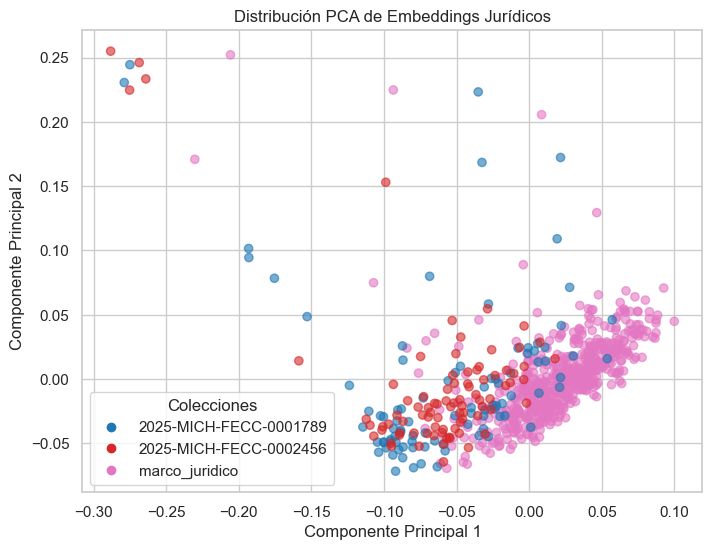

In [47]:
# Visualización de embeddings mediante PCA
plot_embeddings_pca(collections)

En la gráfica ***PCA***, se observa que los embeddings de una misma colección tienden a formar grupos orientados en direcciones similares. Esto respalda el uso de Cosine Similarity, ya que esta métrica se centra en el ángulo entre vectores (dirección semántica) y no en su magnitud, lo cual es consistente con la estructura observada en el espacio de embeddings.

## 5.3. Evaluación de Desempeño

En los últimos años, con el éxito de los sistemas RAG, se ha vuelto necesario el desarrollo de marcos de trabajo y métricas para evaluar el desempeño de estos mismos sistemas. Así pues, a pesar del crecimiento de la investigación relacionada con RAGs, solo algunos pocos artículos describen el estado del arte de las técnicas o métricas para evaluar sistemas del dominio legal.

Según la literatura, existen dos tipos de grupos de métricas para evaluar a un sistema RAG: **Evaluación de Recuperación** y **Evaluación de respuesta**.

### a) Evaluación de Recuperación

Las métricas para evaluar la efectividad del proceso de recuperación y las cuales se utilizarán en el presente trabajo incluyen:

- ***Precision***: fracción de instancias relevantes (aquellas que expertos consideran relevantes del corpus) entre las instancias recuperadas.

- ***Recall***: fracción de instancias relevantes recuperadas del número total de casos relevantes (aquellos que expertos consideran relevantes del corpus).

- ***Mean Reciprocal Rank*** (*MRR*): es el promedio de los rangos recíprocos de la primera respuesta correcta a un conjunto de casos relevantes (aquellos que expertos consideran relevantes del corpus) (Hindi et al., 2025).

In [48]:
# Métricas de evaluación de recuperación de información - RAG

# 1) Precisión en los primeros k resultados
def precision_at_k(retrieved, relevant, k):
    """
    Calcula la precisión en los primeros k resultados de una búsqueda.

    Parámetros:
        retrieved (list) : Lista de IDs de documentos recuperados.
        relevant (set)   : Conjunto de IDs de documentos relevantes.
        k (int)          : Número de resultados a considerar para el cálculo de precisión.

    Retorno:
        float : Precisión@k, proporción de documentos relevantes dentro de los top k resultados.
    """

    # 1) Cálculo de Precision@k
    return len(set(retrieved[:k]) & relevant) / k  # Intersección entre los top k recuperados y los relevantes, dividido por k


# 2) Recall en los primeros k resultados
def recall_at_k(retrieved, relevant, k):
    """
    Calcula el recall en los primeros k resultados de una búsqueda.

    Parámetros:
        retrieved (list) : Lista de IDs de documentos recuperados.
        relevant (set)   : Conjunto de IDs de documentos relevantes.
        k (int)          : Número de resultados a considerar para el cálculo de recall.

    Retorno:
        float : Recall@k, proporción de documentos relevantes recuperados respecto al total de documentos relevantes.
    """

    # 1) Cálculo de Recall@k
    return len(set(retrieved[:k]) & relevant) / len(relevant)  # Intersección entre top k recuperados y relevantes, dividido por total de relevantes


# 3) Mean Reciprocal Rank (MRR)
def mrr(retrieved, relevant):
    """
    Calcula el Mean Reciprocal Rank (MRR) para una lista de resultados recuperados.

    Parámetros:
        retrieved (list) : Lista de IDs de documentos recuperados, ordenados por relevancia.
        relevant (set)   : Conjunto de IDs de documentos relevantes.

    Retorno:
        float : Reciprocal rank del primer documento relevante encontrado. Retorna 0 si no se encuentra ninguno.
    """

    # 1) Iteración sobre los documentos recuperados con su posición
    for rank, doc in enumerate(retrieved, 1): # Comienza la enumeración en 1 para la posición
        if doc in relevant:                   # Verifica si el documento es relevante
            return 1 / rank                   # Retorna el recíproco de la posición del primer documento relevante

    # 2) Retorno si no se encuentra ningún documento relevante
    return 0                                  # Retorna 0 si no hay coincidencias

In [49]:
# Evaluación de Recuperación de RAG

# 1) Definición de la consulta
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""

# 2) Selección de la colección
collection_name = "marco_juridico"

# 3) Recuperación de documentos relevantes
retrieved_data = vector_db_retriever(query, collection_name, embed_model, vector_db, top_k=5)

# 4) Definición de documentos relevantes según expertos
relevant_ids = {209, 210, 211, 562, 563}                                        # Conjunto de IDs considerados relevantes

# 5) Extracción de IDs de los documentos recuperados
retrieved_ids = [item['id'] for item in retrieved_data]               # Lista de IDs de los documentos obtenidos

# 6) Evaluación de métricas de recuperación
print("\n=== Evaluación de Recuperación de RAG ===\n")
print("Precision@5:", precision_at_k(retrieved_ids, relevant_ids, 5)) # Muestra la precisión considerando los top 5 resultados
print("Recall@5:", recall_at_k(retrieved_ids, relevant_ids, 5))       # Muestra el recall considerando los top 5 resultados
print("MRR:", mrr(retrieved_ids, relevant_ids))                       # Muestra el Mean Reciprocal Rank de los resultados

Generando embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


=== Evaluación de Recuperación de RAG ===

Precision@5: 0.2
Recall@5: 0.2
MRR: 0.3333333333333333


### b) Evaluación de Respuesta

El objetivo principal es garantizar que la respuesta sea relevante a la consulta del usuario y evitar alucinaciones. Existen diversas métricas para este rubro. Sin embargo, la métrica que se utilizará es la lla mada ***METEOR*** o ***Metric for Evaluation of Translation with Explicit ORdering***.

***METEOR*** es una métrica que fue originalmente propuesta para la evaluación de sistemas de traducción automática, pero ha demostrado ser altamente efectiva para evaluar la calidad de textos generados por modelos de lenguaje en tareas de generación aumentada por recuperación (RAG).
  
A diferencia de métricas más simples que solo consideran coincidencias exactas de palabras, ***METEOR*** emplea un proceso incremental de alineación léxica entre el texto generado por el modelo y una referencia o “respuesta esperada”.

En este proceso, se consideran coincidencias exactas, coincidencias de palabras con la misma raíz (*stemming*), y coincidencias semánticas mediante sinónimos o paráfrasis.

Una vez realizada esta alineación, se calculan las medidas de **precisión (P)** (proporción de palabras coincidentes respecto al total de palabras generadas) y **recuperación (R)** (proporción de palabras coincidentes respecto al total de palabras de la referencia).

Ambas se combinan en una medida armónica ponderada conocida como ***F-score***, donde se da mayor peso al *recall* para favorecer respuestas más completas:

$$F = \frac{10 \cdot P \cdot R}{9P + R}$$

Posteriormente, ***METEOR*** aplica una penalización basada en la fragmentación del texto, es decir, en el número de "bloques" (*chunks*) de coincidencias consecutivas. Este factor penaliza las respuestas que, aunque contengan las palabras correctas, se presentan de forma desordenada o incoherente. La penalización se define como:

$$\lambda = 0.5 \left(\frac{u}{n}\right)^3$$

donde *u* es el número de unigramas coincidentes y *n* el número de bloques o secuencias coincidentes.

Finalmente, el puntaje ***METEOR*** se obtiene como:

$$\text{METEOR} = (1 - \lambda) \cdot F$$

En este proyecto, ***METEOR*** permite evaluar la **calidad semántica y lingüística de las respuestas generadas por el modelo baseline**, contrastándolas con una referencia jurídica esperada.

Esto resulta especialmente relevante en el dominio legal, donde la **precisión terminológica y la fidelidad semántica** son esenciales para evitar errores interpretativos o respuestas alucinadas.

De este modo, ***METEOR*** complementa las métricas de recuperación al ofrecer una **evaluación integral del desempeño del sistema RAG**, considerando tanto la efectividad de la búsqueda de información como la calidad del texto generado por el modelo de lenguaje (Louis et al., 2023).

In [50]:
# Evaluación de Respuesta de RAG

# 1) Consulta y configuración inicial
query = """Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal."""
collection_name = "marco_juridico"

# 2) Recuperación de documentos relevantes
retrieved_data = vector_db_retriever(query, collection_name, embed_model, vector_db, top_k=5)
context_docs = [item["text"] for item in retrieved_data]

# 3) Definición de la respuesta de referencia
reference = """El CNPP establece que las medidas cautelares deben aplicarse de forma excepcional, proporcional y temporal,
con la finalidad de garantizar la presencia del imputado, proteger a la víctima y asegurar el desarrollo del proceso penal,
sin afectar la presunción de inocencia, según el artículo 153 del mismo.
"""

# 4) Generación de respuesta del modelo LLM
response = generate_llm_response(llm_model, query, context_docs)

# 5) Cálculo de la métrica METEOR
# Tokenize the reference and response before calculating METEOR
tokenized_reference = word_tokenize(reference)
tokenized_response = word_tokenize(response)
meteor = meteor_score([tokenized_reference], tokenized_response)  # Calcula la similitud entre la respuesta generada y la referencia

# 6) Impresión de resultados de la evaluación
print("\n********** Evaluación de Respuesta de RAG **********\n")

print("\n=== Pregunta ===\n")
print(query)
print("\n=== Respuesta esperada ===\n")
print(reference)
print("\n=== Respuesta generada ===\n")
print(response)
print("\n=== METEOR Score ===\n")
print(meteor)                                                     # Muestra el puntaje METEOR con cuatro decimales

Generando embeddings: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]



********** Evaluación de Respuesta de RAG **********


=== Pregunta ===

Explica qué establece el Código Nacional de Procedimientos Penales sobre las condiciones,
límites y finalidad de las medidas cautelares aplicables durante el proceso penal.

=== Respuesta esperada ===

El CNPP establece que las medidas cautelares deben aplicarse de forma excepcional, proporcional y temporal,
con la finalidad de garantizar la presencia del imputado, proteger a la víctima y asegurar el desarrollo del proceso penal,
sin afectar la presunción de inocencia, según el artículo 153 del mismo.


=== Respuesta generada ===

**
    1. Responde a la pregunta tomando como base al contexto, pero sin limitarte a este (puedes argumentar más allá del contexto no te limítes).
    2. Incluye **citas directas** o referencias al documento original (si está disponible en el Contexto).

    --- CONTEXTO ---
    artículo 5 ) . onu , asamblea general , responsabilidad del estado por

justificación : dado que el derecho a

# 6. Conclusiones

En el presente trabajo, se revisó toda la estructura para el procesamiento de un **Corpus de Texto**, así como la generación de *chunks* y *embeddings* con base en el mismo. Además, la parte central de este entregable se enfoca en la estructuración del *+Algoritmo** a utilizar por el proyecto. Este último está representado por un sistema **RAG**, el cual como se detalla en las secciones correspondientes, incluye tanto una **Base de Datos Vectorial**, como un modelo **LLM**.

El flujo de trabajo del proyecto hasta el momento de este entragable, está compuesto por:

  1. **Construcción del Corpus de Texto**: identificación y lectura del contenido de los documentos de las **Carpetas de Investigación** y **Marco Jurídico**.

  2. **Preprocesamiento del Corpus de Texto**: *tokenizaicón* y generación de *chunks* de los textos. Los *chunks* son de diverso tamaño hasta los *4,096* *tokens* con el objetivo de preservar contexto y estructuras.

  3. **Generación de Embeddings**: utilización del modelo `e5-base-4k` (que permite grandes ventanas) para generar *embeddigns* de *chunks* que pueden llegar hasta los *4,096* *tokens*. También, se introdujo un método de *subchunking* basado en **ventana deslizante** (*sliding window*). Esto último, con el objetivo de dividir cada *chunk* del **Corpus de Texto** en subfragmentos más manejables y tratar de combatir el problema de **colapso de embedding** o *embedding collapse* donde los *embeddings* de *chunks* largos tienden a agruparse demasiado en el espacio vectorial.

  4. **Modelo Baseline del Sistema RAG**:

      a) **Base de Datos Vectorial**: para guardar los *embeddings* y la metadata relacionada con estos (texto, *chunks*, etc.) se optó por utilizar la base de datos `Qdrant`, que es muy flexible para manejar información de diversos tamaños y configurarse en diferentes entornos.

      b) **LLM**: se utilizó el modelo `google/gemma-2-2b-it`. Este modelo es relativamente limitado al estar entrenado con entorno a 2 billones de parámetros. Pero, es muy flexible al trabajar con él en entornos de prueba o de creación de productos mínimos viables como es este el caso.

En conclusion, una vez configurado todo el flujo de trabajo, incluyendo la nueva etapa del **Modelo Baseline del Sistema RAG**, se procedió a evaluar su rendimiento basado en dos diferentes grupos de métricas. Una fue la evaluación de recuperación, centrada en la efectividad del proceso de recuperación (relacionada con la **Base de Datos Vectorial**) y la segunda fue la evaluación de respuesta (relacionada con el **LLM**).

En cuanto a la evaluación de recuperación, se puede observar que el sistema entrega algunas métricas a considerar como una *precision* de *.2*, *recall* de *.3* o *mrr* de *.3* (las cuales evaluaron los documentos traídos por la base de datos utilizando similitud coseno o *cosine similarity, contra los documentos que expertos mencionan relevantes). Sin embargo, al analizarse e interpretarse estas métricas, se puede determinar que la recuperación del sistema está actuando de manera pobre. Algunas de las acciones que se podrían tomar en este rubro serían las de implementar un **Cross-Encoder** para identificar documentos mayormente relacionados con la consulta sobre los documentos recuperados. Otra cuestión, sería la de modificar la generación de *chunks* y *embeddings*, ya que probablemente está existiendo el problema mencionado de *embedding collapse*. Para esto se podría tratar de observar otro proceso de *Chunking* o la utilización de otro modelo de generación de *embeddings*

Por otro lado, en cuanto a la evaluación de respuesta se utilizó la métrica *METEOR*, la cual combina un *recall* basado en unigramas y una precisión de correspondencias (*matches*) que considera la alineación exacta, la raíz de la palabra (*stemming*) y el uso de sinónimos, además de aplicar una penalización por fragmentación (*fragmentation penalty*) para favorecer las frases largas y fluidas. Esto al comparar la respuesta esperada diseñada con base en el **Corpus de Texto** y la respuesta hecha por el **LLM**. Para este trabajo el sistema **RAG** obtuvo un valor muy bajo (entre más cercano a 1 mejor es el modelo según *METEOR*, entre más cercano 0 es peor. El presente trabajo obtuvo un valor muy bajo), lo que indica que la calidad de las respuestas generadas es deficiente en comparación con las respuestas de referencia. Para mejorar esta parte del sistema, existen varias alternativas, como la selección de un mejor modelo, más grande y robusto, entrenado en más parámetros y posiblemente entrenado para tareas legales concretas. Otra solución sería la implementación de *Query Expansion* que es una técnica que ayuda a reinterpretar y dar una mejor composición a la consulta que entra el **LLM**.

En conclusion, aunque se logró construir un **Modelo Baseline del Sistema RAG** y se construyó un flujo de trabajo funcional, las métricas (evaluación de la recuperación y de respuestas) y el análisis de los resultados (documentos recuperados y respuestas del sistema), dejan mucho que desear. Pues, el rendimiento observado es pobre, alentando a la mejora del sistema, al integrar mejores componentes y técnicas como las mencionadas en los anteriores párrafos.

# 7. Referencias

- Aytar, A. Y., Kaya, K., & Kılıç, K. (2025). A synergistic multi-stage RAG architecture for boosting context relevance in data science literature. *Natural Language Processing Journal*, *13*, 100179. https://doi.org/10.1016/j.nlp.2025.100179.

- Barnett, S., Kurniawan, S., Thudumu, S., Brannelly, Z., & Abdelrazek, M. (2024). *Seven Failure Points When Engineering a Retrieval Augmented Generation System*. arXiv. https://arxiv.org/abs/2401.05856.

- Dong, J., Fatemi, B., Perozzi, B., Yang, L. F., & Tsitsulin, A. (2024). *Don't Forget to Connect! Improving RAG with Graph-based Reranking*. arXiv. https://arxiv.org/abs/2405.18414.

- Gao, Y., Xiong, Y., Gao, X., Jia, K., Pan, J., Bi, Y., Dai, Y., Sun, J., Wang, Q., Wang, M., & Wang, H. (2024). *Retrieval-Augmented Generation for Large Language Models: A Survey*. [Preprint]. arXiv. https://doi.org/10.48550/arXiv.2312.10997.

- Günther, M., Mohr, I., Williams, D. J., Wang, B., & Xiao, H. (2025). *Late Chunking: Contextual Chunk Embeddings Using Long-Context Embedding Models*. arXiv. https://arxiv.org/pdf/2409.04701.

- Hindi, M., Mohammed, L., Maaz, O., & Alwarafy, A. (2025). Enhancing the Precision and Interpretability of Retrieval-Augmented Generation (RAG) in Legal Technology: A Survey. *IEEE Access*, *13*, 46171-46189. https://doi.org/10.1109/ACCESS.2025.3550145.

- Hugging Face. (2024, 21 de febrero). *google/gemma-2-2b-it*. Hugging Face Hub. https://huggingface.co/google/gemma-2-2b-it.

- Hugging Face. (2025, 31 de marzo). *cross-encoder/ms-marco-MiniLM-L6-v2*. Hugging Face Hub. https://huggingface.co/cross-encoder/ms-marco-MiniLM-L6-v2.

- Loo, A., Pavlick, E., & Feiman, R. (2026). LLMs model how humans induce logically structured rules. *Journal of Memory and Language*, *146*, 104675. https://doi.org/10.1016/j.jml.2025.104675.

- Louis, A., van Dijck, G., & Spanakis, G. (2023). *Interpretable Long-Form Legal Question Answering with Retrieval-Augmented Large Language Models*. arXiv. https://doi.org/10.48550/arXiv.2309.17050.

- Qdrant. (2023, 1 de junio). *Cronología: Mujeres del mundo únanse*.  https://qdrant.tech/documentation/overview/.

- Rahim, M., Abosuliman, S. S., Alroobaea, R., Shah, K., & Abdeljawad, T. (2024). Cosine similarity and distance measures for p, q- quasirung orthopair fuzzy sets: Applications in investment decision-making. *Heliyon*, *10*, e32107. https://doi.org/10.1016/j.heliyon.2024.e32107.

- Xiong, Y., Tu, X., & Zhao, W. (2025). AFR-Rank: An effective and highly efficient LLM-based listwise reranking framework via filtering noise documents. *Information Processing and Management*, *62*, 1-14. https://doi.org/10.1016/j.ipm.2025.104232.